## Simple transfer learning

In [ ]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
classifier_model = mobilenet_v2 
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

In [ ]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [ ]:
data_root = tf.keras.utils.get_file(
  'flower_photos',
  'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

First, load this data into the model using the image data off disk with `tf.keras.utils.image_dataset_from_directory`, which will generate a `tf.data.Dataset`:

In [ ]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


The flowers dataset has five classes:

In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Running Classifier on batch

In [ ]:
result_batch = classifier.predict(train_ds)

In [ ]:
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

Check how these predictions line up with the images:

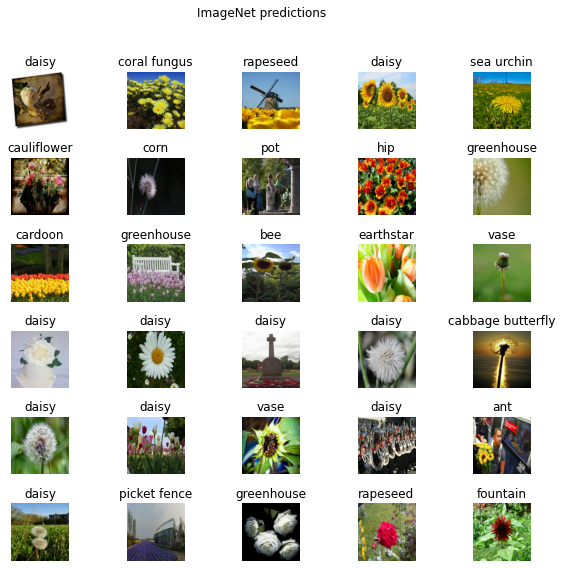

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

In [ ]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

In [ ]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [ ]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

<!-- <img class="tfo-display-only-on-site" src="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/images/images/tensorboard_transfer_learning_with_hub.png?raw=1"/> -->

In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)